## CIFAR10 데이터셋 확인

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from src.data_utils import DatasetCIFAR10, plot_img
from src.train import NoiseScaler, TrainLoader

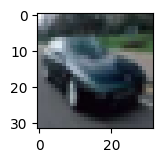

Label: automobile


In [ ]:
dataset = DatasetCIFAR10("./diffusion_example/cifar-10-batches-py")
dataset.load()
dataset.show_index(11000)

## Noise variance scheduling 파라미터 확인

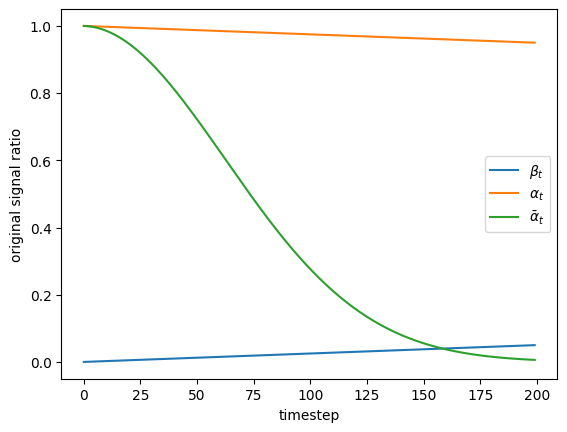

In [2]:
from yacs.config import CfgNode

with open("./diffusion_example/src/training_config.yml", "r") as f:
    cfg = CfgNode.load_cfg(f)
    num_steps = cfg.TRAIN.TOTAL_STEPS  # 사용할 총 스텝 수 = 200 (논문에선 1000)
    beta_start = cfg.TRAIN.BETA_1  # = 0.0001
    beta_end = cfg.TRAIN.BETA_T  # = 0.05 (논문에선 0.01)

betas = np.linspace(beta_start, beta_end, num_steps)  # 베타 스케줄링
noise_scaler = NoiseScaler(betas=betas, num_steps=num_steps)

fig, ax = plt.subplots()
ax: plt.Axes
ax.plot(noise_scaler.betas)
ax.plot(noise_scaler.alphas)
ax.plot(noise_scaler.alpha_bars)
ax.set_xlabel("timestep")
ax.set_ylabel("original signal ratio")
ax.legend([r"$\beta_t$", r"$\alpha_t$", r"$\bar{\alpha}_t$"])
plt.show()
plt.close()

## 데이터로더 테스트

t: 18.0 | label: automobile


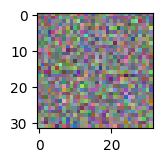

In [11]:
loader = TrainLoader(
    dataset=dataset,
    noise_scaler=noise_scaler,
    batch_size=4,
)
batches = (b for b in loader)
x_t, noise, steps, labels = next(batches)
print(f"t: {steps[0]} | label: {DatasetCIFAR10.INVERSE_LABELS_MAP[labels[0].item()]}")
plot_img(x_t[0])
plot_img(noise[0])

## Conditional Unet 훈련

In [8]:
import os
os.system("torchrun --nproc_per_node 3 ./diffusion_example/src/train.py --gpus 0 1 2")

[2024-06-11 10:22:52,805] torch.distributed.run: [WARNING] 
[2024-06-11 10:22:52,805] torch.distributed.run: [WARNING] *****************************************
[2024-06-11 10:22:52,805] torch.distributed.run: [WARNING] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
[2024-06-11 10:22:52,805] torch.distributed.run: [WARNING] *****************************************


Number of batches: 1563
Number of batches: 1563
Number of batches: 1563


Epoch: 1 :   0%|          | 0/1563 [00:00<?, ?it/s]/home/honggyu/miniconda3/envs/ddpm/lib/python3.11/site-packages/torch/autograd/__init__.py:266: UserWarning: Grad strides do not match bucket view strides. This may indicate grad was not created according to the gradient layout contract, or that the param's strides changed since DDP was constructed.  This is not an error, but may impair performance.
grad.sizes() = [3, 64, 1, 1], strides() = [64, 1, 64, 64]
bucket_view.sizes() = [3, 64, 1, 1], strides() = [64, 1, 1, 1] (Triggered internally at ../torch/csrc/distributed/c10d/reducer.cpp:322.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/honggyu/miniconda3/envs/ddpm/lib/python3.11/site-packages/torch/autograd/__init__.py:266: UserWarning: Grad strides do not match bucket view strides. This may indicate grad was not created according to the gradient layout contract, or that the param's strides changed since DDP was constructed.  Thi

하지만 주피터커널에선 os동작을 끊기가 힘들어서 -> 터미널에서 스크립트로 따로 돌리는 것을 권장드립니다

## Denoising Generator 준비

In [ ]:
import numpy as np
import torch
from yacs.config import CfgNode

from src.data_utils import DatasetCIFAR10
from src.unet import UNetConditional
from src.generation import (
    Generator,
    Predictor,
    Preprocessor,
)

num_channels = 3  # RGB channels
device = torch.device("cuda:3")

# initializing model
with open("./diffusion_example/src/training_config.yml", "r") as f:
    cfg = CfgNode.load_cfg(f)
    beta_start = cfg.TRAIN.BETA_1
    beta_end = cfg.TRAIN.BETA_T
    num_steps = cfg.TRAIN.TOTAL_STEPS

model = UNetConditional(
    cfg=cfg,
    c_in=num_channels,
    c_out=num_channels,
    num_classes=DatasetCIFAR10.NUM_LABELS,
)
# 130K steps (400K 까지는 해야하는듯..)
model_state_dict = torch.load("./diffusion_example/checkpoints/epoch_84.pt")
model.load_state_dict(model_state_dict)
model.to(device)
model.eval()

# initializing generator
betas = np.linspace(beta_start, beta_end, num_steps)  # t=0 ~ t=num_steps (훈련 때 썼던 것과 동일하게)
generator = Generator(
    preprocessor=Preprocessor(
        labels_map=DatasetCIFAR10.LABELS_MAP,
    ),
    predictor=Predictor(
        model=model,
        betas=betas,
        imsize=DatasetCIFAR10.IMAGE_SIZE,
        device=device,
    ),
)

## DDPM 생성

### 단일 샘플 생성

Generating label automobile...
Encoded label #: 1


 54%|█████▎    | 107/200 [00:00<00:00, 175.86it/s]

100%|██████████| 200/200 [00:01<00:00, 176.19it/s]


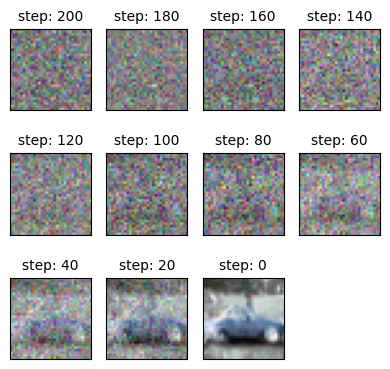

1.4166438579559326


In [8]:
from time import time
st = time()
x_hist = generator.generate(
    method="ddpm",
    stride=20,
    label="automobile",
    fig_size=(4, 4),
)
ft = time()
print(ft - st)

### 병렬 생성

Generating 15 images of label airplane...
Encoded label #: 0


100%|██████████| 200/200 [00:02<00:00, 81.26it/s]


Generating 15 images of label automobile...
Encoded label #: 1


100%|██████████| 200/200 [00:02<00:00, 81.62it/s]


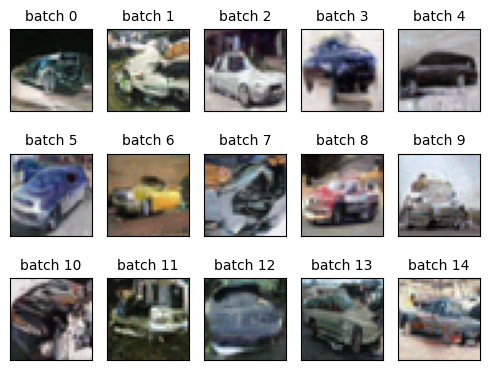

Generating 15 images of label bird...
Encoded label #: 2


100%|██████████| 200/200 [00:02<00:00, 81.73it/s]


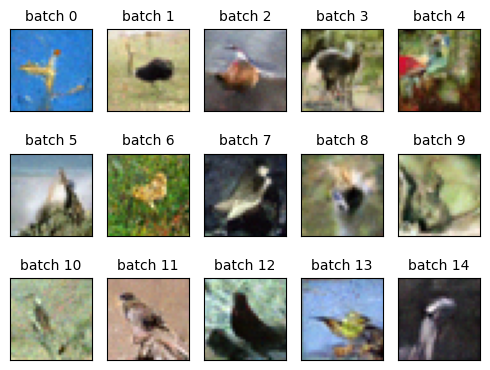

Generating 15 images of label cat...
Encoded label #: 3


100%|██████████| 200/200 [00:02<00:00, 81.38it/s]


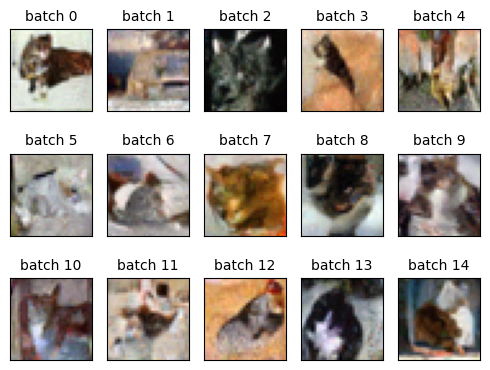

Generating 15 images of label deer...
Encoded label #: 4


100%|██████████| 200/200 [00:02<00:00, 80.66it/s]


Generating 15 images of label dog...
Encoded label #: 5


100%|██████████| 200/200 [00:02<00:00, 80.38it/s]


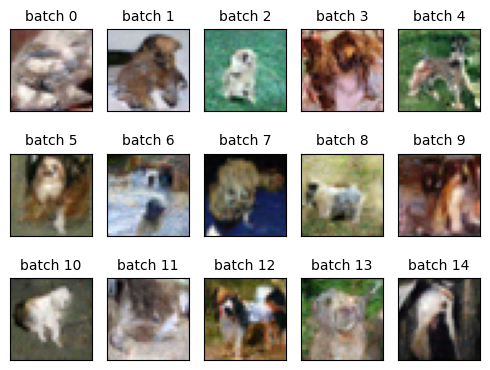

Generating 15 images of label frog...
Encoded label #: 6


100%|██████████| 200/200 [00:02<00:00, 81.77it/s]


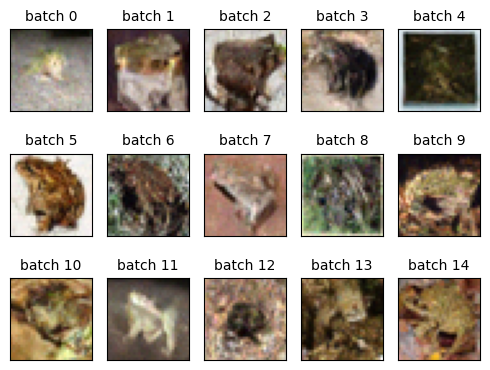

Generating 15 images of label horse...
Encoded label #: 7


100%|██████████| 200/200 [00:02<00:00, 80.76it/s]


Generating 15 images of label ship...
Encoded label #: 8


100%|██████████| 200/200 [00:02<00:00, 81.54it/s]


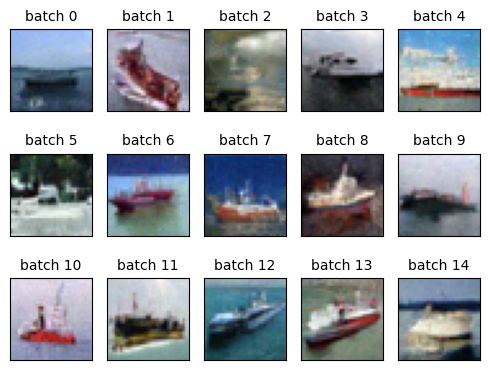

Generating 15 images of label truck...
Encoded label #: 9


100%|██████████| 200/200 [00:02<00:00, 81.22it/s]


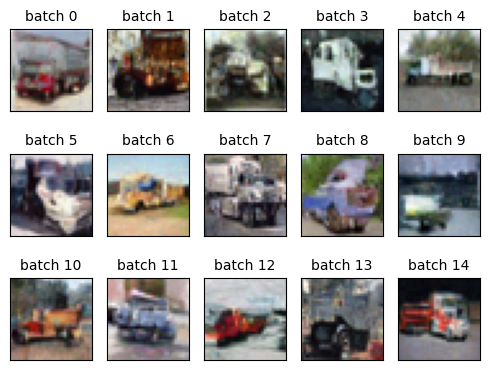

In [42]:
for label in DatasetCIFAR10.LABELS_MAP.keys():
    generator.generate_parallel(
        method="ddpm",
        label=label,
        n=15,
        fig_size=(5, 4),
    )

## DDIM 생성

### 10배 가속 단일샘플 생성

In [40]:
ts = np.arange(0, num_steps + 1)[::10]  # 10배 가속
_ = generator.generate(
    method="ddim",
    label="automobile",
    ts=ts,
    stride=2,  # 2번 건너 플롯 (즉, 20 step마다)
    eta=0,
    fig_size=(4, 4),
)

Generating label automobile...
Encoded label #: 1


100%|██████████| 20/20 [00:00<00:00, 150.86it/s]


### 10배 가속 병렬 생성

Generating 15 images of label airplane...
Encoded label #: 0


100%|██████████| 20/20 [00:00<00:00, 75.68it/s]


Generating 15 images of label automobile...
Encoded label #: 1


100%|██████████| 20/20 [00:00<00:00, 80.07it/s]


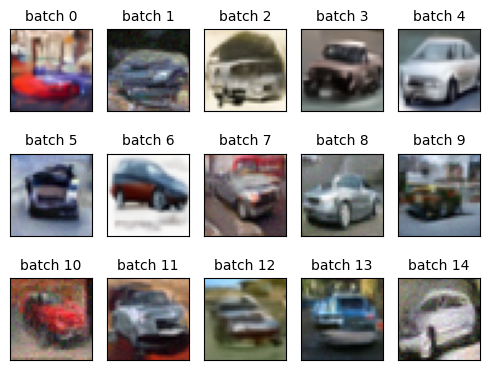

Generating 15 images of label bird...
Encoded label #: 2


100%|██████████| 20/20 [00:00<00:00, 79.55it/s]


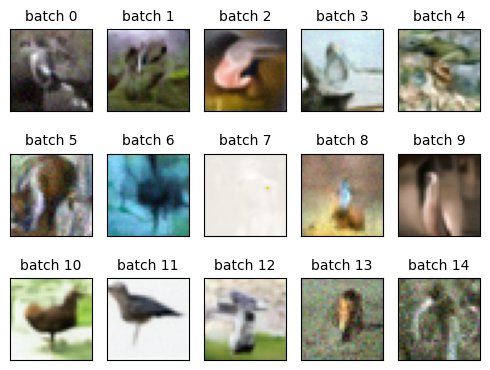

Generating 15 images of label cat...
Encoded label #: 3


100%|██████████| 20/20 [00:00<00:00, 80.32it/s]


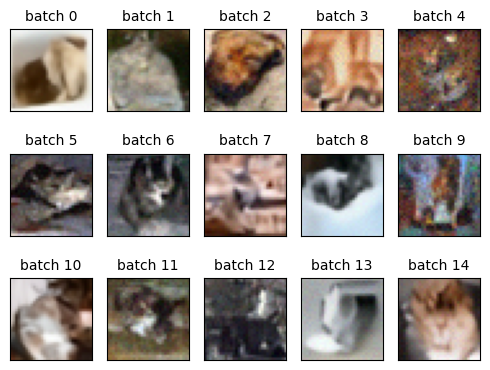

Generating 15 images of label deer...
Encoded label #: 4


100%|██████████| 20/20 [00:00<00:00, 79.92it/s]


Generating 15 images of label dog...
Encoded label #: 5


100%|██████████| 20/20 [00:00<00:00, 80.27it/s]


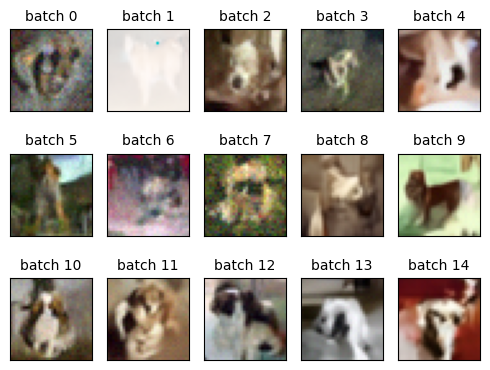

Generating 15 images of label frog...
Encoded label #: 6


100%|██████████| 20/20 [00:00<00:00, 81.05it/s]


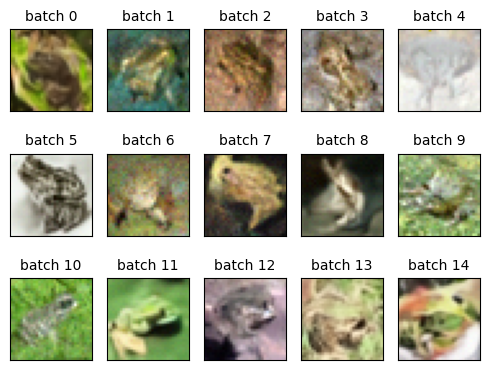

Generating 15 images of label horse...
Encoded label #: 7


100%|██████████| 20/20 [00:00<00:00, 80.97it/s]


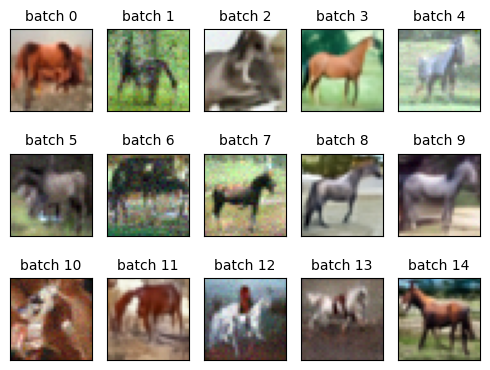

Generating 15 images of label ship...
Encoded label #: 8


100%|██████████| 20/20 [00:00<00:00, 81.12it/s]


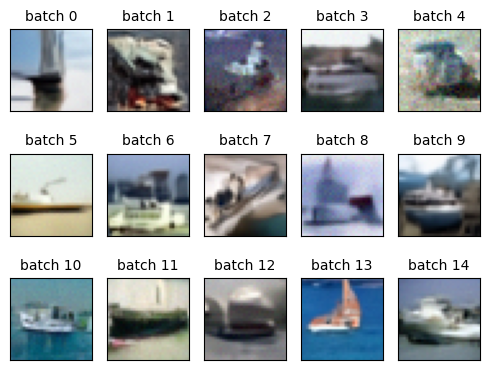

Generating 15 images of label truck...
Encoded label #: 9


100%|██████████| 20/20 [00:00<00:00, 80.60it/s]


In [41]:
for label in DatasetCIFAR10.LABELS_MAP.keys():
    generator.generate_parallel(
        method="ddim",
        label=label,
        n=15,
        ts=ts,
        eta=0.5,
        fig_size=(5, 4),
    )